In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import RandomOverSampler


In [72]:
import warnings
warnings.filterwarnings("ignore")

# Importing the data

In [73]:
df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
df

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no


In [74]:
print("Number of Rows in the Training dataset", df.shape[0])
print("Number of Columns in the Training dataset(including target column)", df.shape[1])

Number of Rows in the Training dataset 39211
Number of Columns in the Training dataset(including target column) 16


## Checking the type of dataset

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

## Checking the missing values in the dataset

In [76]:
df.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

# Exploratory Data Analysis (EDA)
### It’s a critical step in the data analysis and machine learning workflow, where you explore and understand the underlying structure, patterns, and characteristics of the dataset. The goal of EDA is to gain insights into the data, identify potential issues, and inform the next steps in the analysis or modeling process.

## Target Distribution

Text(0, 0.5, 'Count')

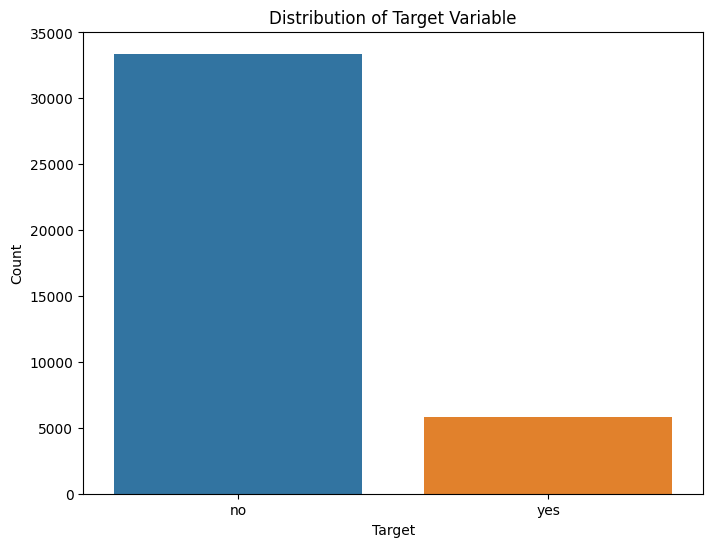

In [77]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

The count plot of the target variable visually displays the distribution of the outcome in the dataset. By comparing the counts for each category in target, we determine that there is a 85:15 imbalance in the dataset

## Correlation heatmap of Numerical Features

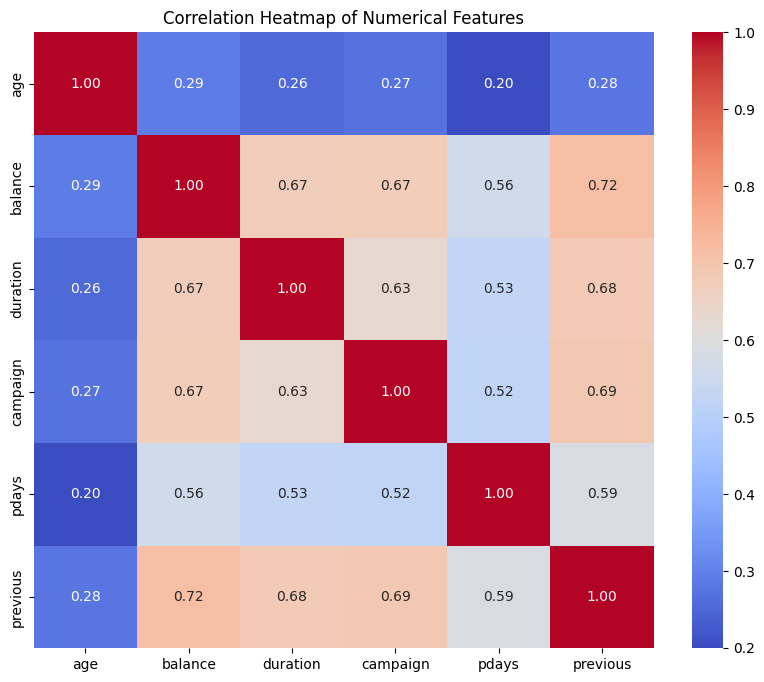

In [78]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

* balance and previous (0.72): Customers with higher balances tend to have more previous contacts. This could imply that more financially stable customers have had multiple engagements with the campaign.
* age has relatively lower correlations with other variables. This may indicate that age is not as influential on balance, duration, or other engagement-related features, suggesting that financial and engagement factors may hold more predictive value than demographic ones.

## Countplot of Categoral Features

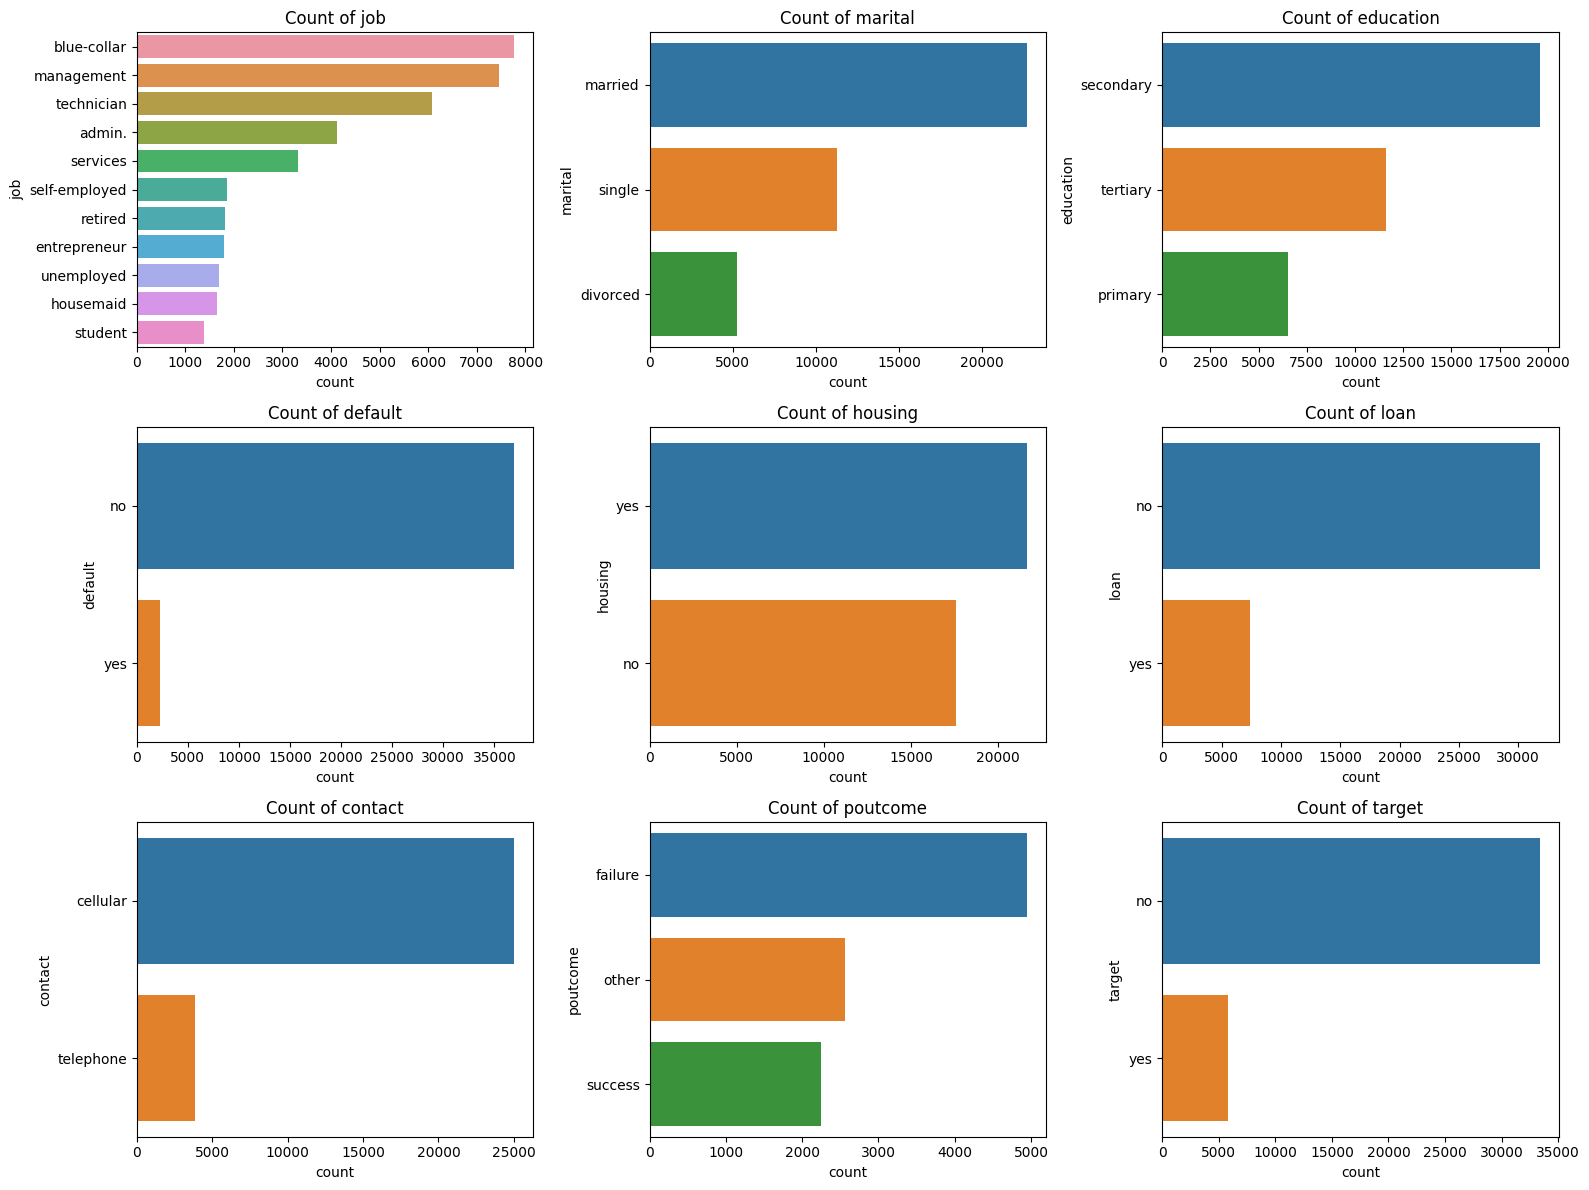

In [79]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'target']

plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()

1. Job: The count of different job types can indicate the dataset’s demographic reach. If some jobs (e.g., “blue-collar” or “admin”) have significantly higher counts, they might be key demographic targets or could influence the target variable in unique ways.
2. Marital Status: Understanding the distribution across marital statuses (e.g., married, single) provides insight into customer segments. If one status is significantly dominant, this may suggest a primary customer demographic.
3. Education: Higher counts for certain education levels (like secondary or tertiary) can give clues about the level of education most common among customers. This information can help design campaigns tailored to these educational backgrounds.
4. Default Status: Examining the “default” column can show how many customers have previous loan defaults. A high count for “no” (no previous default) suggests a financially stable customer base, which could affect the likelihood of successful campaign outcomes.
5. Housing and Personal Loans: High counts of customers with or without housing or personal loans can indicate their financial commitments, potentially impacting their responsiveness to marketing.
6. Contact Type: The count of different contact methods (e.g., cellular, telephone) can show the primary channels through which customers are reached. The most common method might be the preferred or most effective communication channel for this audience.
7. Previous Outcome (poutcome): If a large portion of customers have a certain previous outcome (e.g., success or failure), this can help understand prior campaign effectiveness. A dominant category here might indicate past engagement success or lack thereof.
8. Target: The target variable distribution (usually “yes” or “no”) reveals the class balance in the outcome. If one category significantly outweighs the other, it suggests class imbalance, which might need addressing before model training.

## Boxplots for Numerical Features

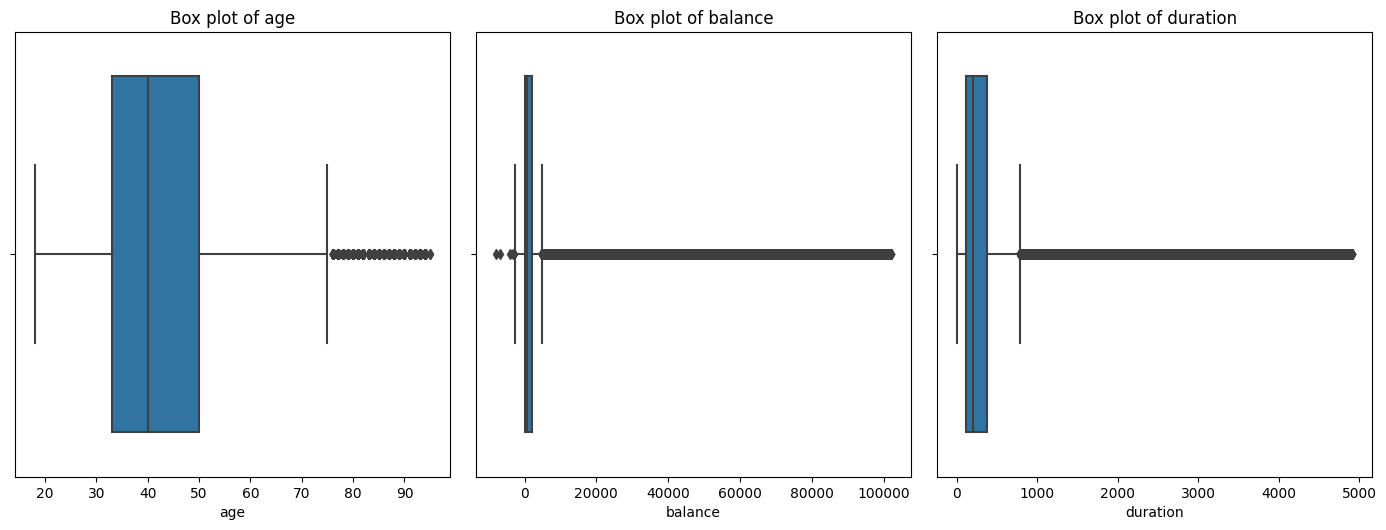

In [80]:
numerical_cols = ['age', 'balance', 'duration']

plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

1. Age

* 	•	Range: The age of customers spans from 18 to 95 years, with a median age of around 40 years.
* 	•	Distribution: The age data appears fairly spread out, with a standard deviation of about 12.7. The interquartile range (IQR) is from 33 to 50 years, indicating that most customers are in this age range.
* 	•	Outliers: While extreme ages (above 70) could be considered outliers in some datasets, they may represent a smaller group of older customers in this context.

2. Balance

	•	Range: The balance variable ranges from -8,019 to 102,127, with a median balance of around 549.
	•	Distribution: The large standard deviation (16,365) and high max value indicate that while most customers have relatively modest balances, a few have extremely high balances, which may represent a wealthier customer segment.
	•	Outliers: There are negative balance values, possibly indicating debt or overdrafts, and high positive values, which might need treatment (e.g., log transformation) to handle extreme values in predictive modeling.

3. Duration

* 	•	Range: Duration ranges from 0 (indicating no engagement or a missed contact) up to 4,918 seconds, with a median duration of 197 seconds.
* 	•	Distribution: A high standard deviation (769) and a large IQR suggest that most engagements are brief, but there are some notably longer interactions.
* 	•	Outliers: Extremely high durations (above 1,000 seconds) could represent unique cases of prolonged engagement, which might influence the customer’s likelihood of a positive response.

 ## Column wise distribution by target

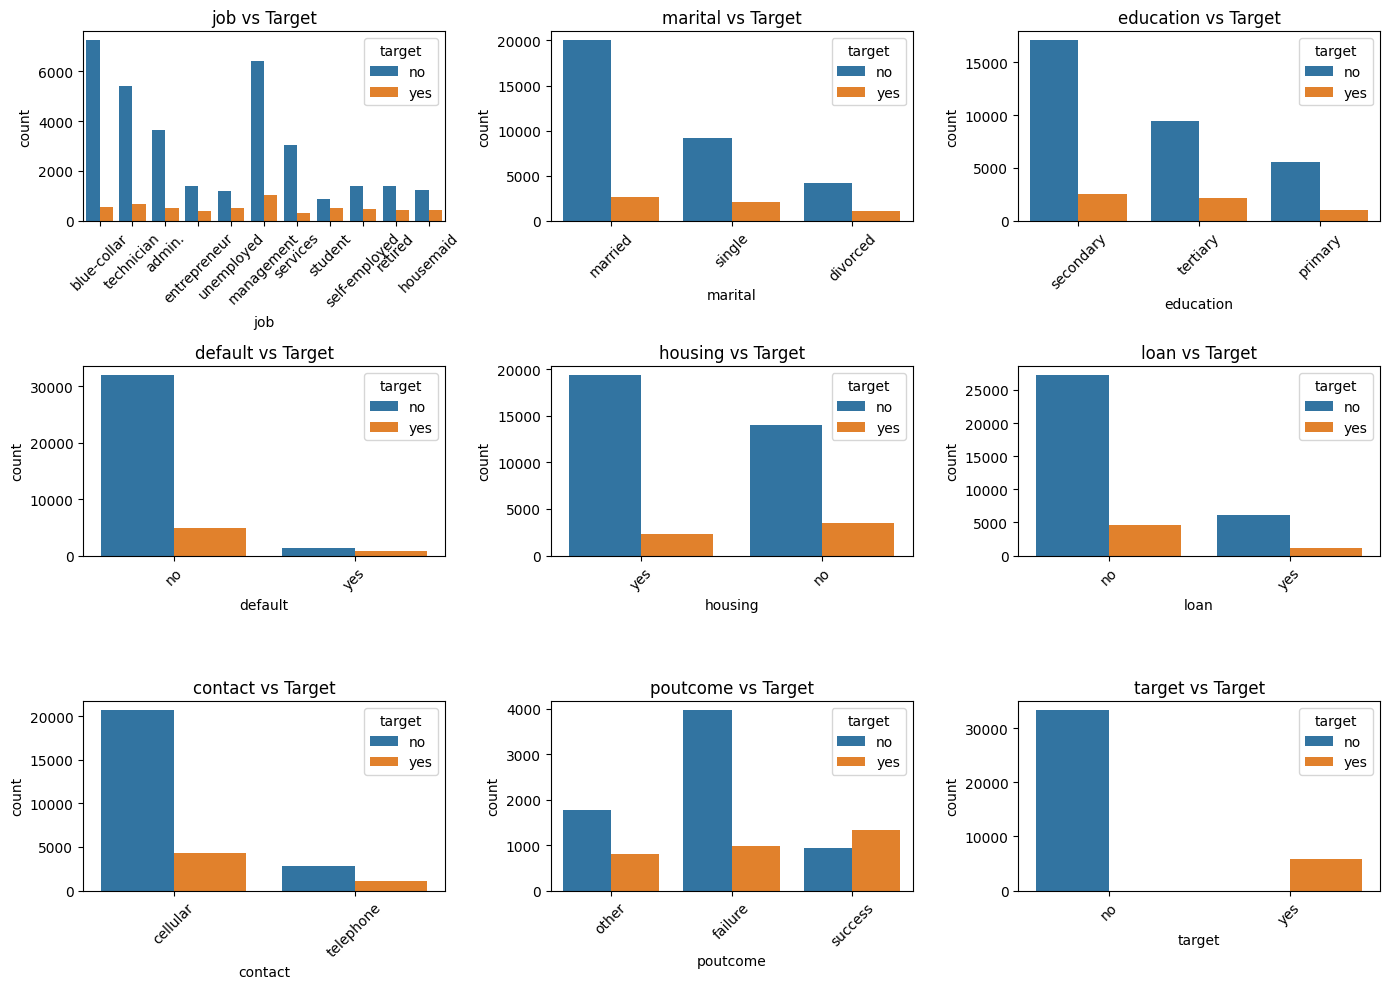

In [81]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, hue='target', data=df)
    plt.title(f'{col} vs Target')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Job vs Target:
	-	Certain job types may show a stronger association with a particular target outcome (e.g., “yes” or “no”). For example, if “technicians” or “management” roles have higher proportions of “yes” responses, these job categories might be more receptive to the campaign.
2.	Marital Status vs Target:
	-	If one marital status category (e.g., “married” or “single”) has a higher ratio of positive target outcomes, this could indicate that specific relationship statuses correlate with the target response. Such insights can help in tailoring strategies for different marital demographics.
3.	Education vs Target:
	-	Higher education levels may correspond with higher positive outcomes if, for instance, tertiary-educated individuals show more “yes” responses. This could reflect how education level influences campaign responsiveness or purchasing power.
4.	Default vs Target:
	-	A high ratio of “yes” outcomes among customers with no loan defaults may suggest that those without defaults are more likely to respond positively. This is valuable for targeting financially stable customers.
5.	Housing Loan vs Target:
	-	If customers without housing loans show more “yes” responses, this might indicate that customers with fewer financial commitments are more likely to engage.
6.	Personal Loan vs Target:
	-	Similar to housing loans, customers without personal loans may have a different engagement rate, perhaps due to fewer financial obligations affecting their responsiveness.
7.	Contact Type vs Target:
	- The effectiveness of each contact method (e.g., “cellular” or “telephone”) can be observed if one contact type leads to more positive outcomes. This could help determine the most effective communication channels.
8.	Previous Outcome (poutcome) vs Target:
	- A high proportion of positive target outcomes for a specific previous outcome category (e.g., “success” or “failure”) could indicate the impact of past engagement success on current campaign response rates.
9.	Target Variable Distribution Across Categories:
	- Observing the distribution of the target variable across categories reveals which demographics or behaviors correlate with positive responses. This helps in identifying key segments and refining targeting strategies.


## Time Series Analysis based on Month by target

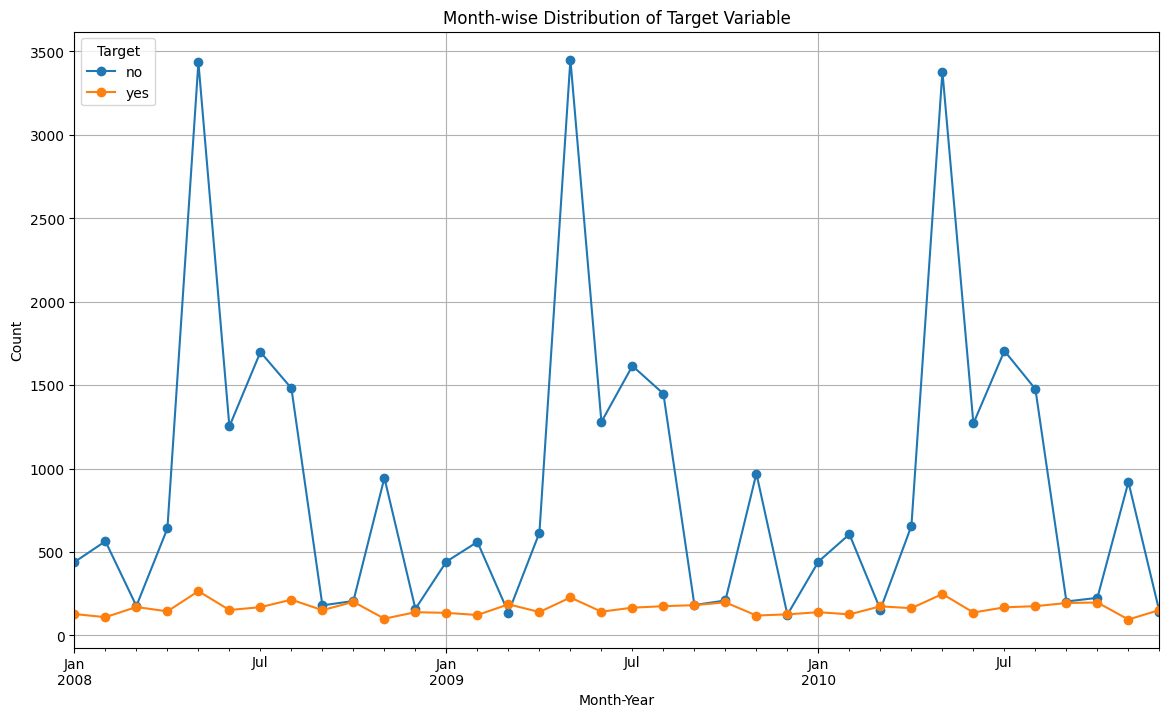

In [82]:
df['last_contact_date'] = pd.to_datetime(df['last contact date'], errors='coerce')

df['month_year'] = df['last_contact_date'].dt.to_period('M')

monthly_target_distribution = df.groupby(['month_year', 'target']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
monthly_target_distribution.plot(kind='line', marker='o', ax=plt.gca())
plt.title("Month-wise Distribution of Target Variable")
plt.xlabel("Month-Year")
plt.ylabel("Count")
plt.legend(title='Target', loc='upper left')
plt.grid(visible=True)
plt.show()

## Time Series Analysis based on days of month by target

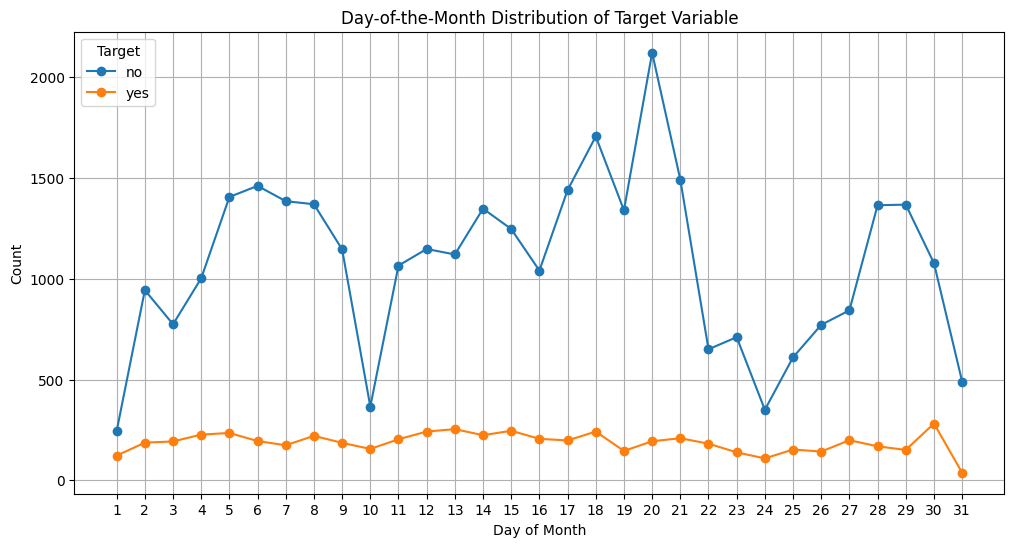

In [83]:
df['day_of_month'] = df['last_contact_date'].dt.day

daily_target_distribution = df.groupby(['day_of_month', 'target']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
daily_target_distribution.plot(kind='line', marker='o', ax=plt.gca())
plt.title("Day-of-the-Month Distribution of Target Variable")
plt.xlabel("Day of Month")
plt.ylabel("Count")
plt.xticks(range(1, 32))
plt.legend(title='Target', loc='upper left')
plt.grid(visible=True)
plt.show()

## Age Distribution by target

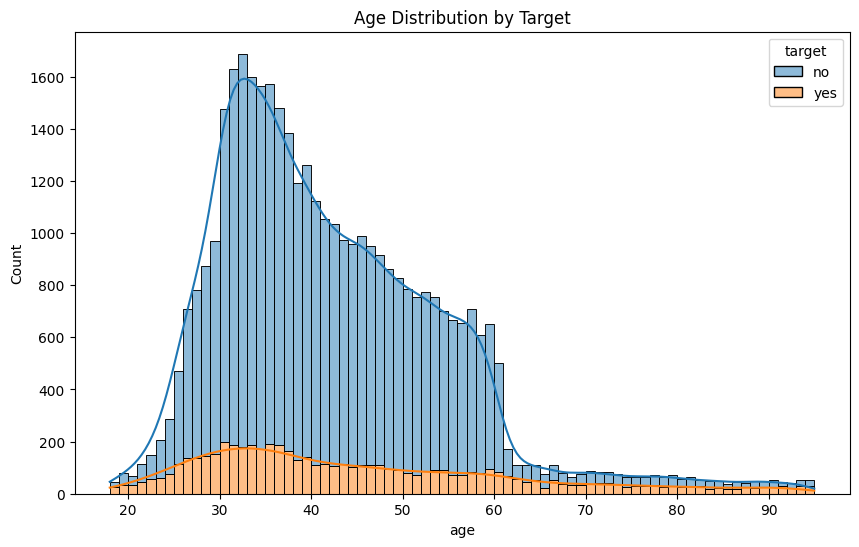

In [84]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='age', hue='target', multiple='stack', kde=True)
plt.title('Age Distribution by Target')
plt.show()

## Scatterplot for Duration and Age by target

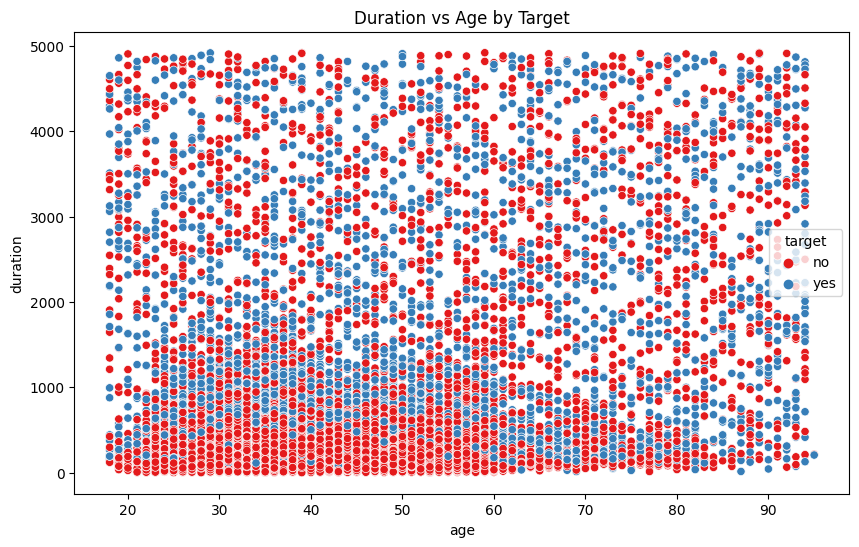

In [85]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='duration', hue='target', data=df, palette='Set1')
plt.title('Duration vs Age by Target')
plt.show()

# Feature Engineering and Preprocessing

In [86]:
df['year'] = pd.to_datetime(df['last contact date']).dt.year
df['month'] = pd.to_datetime(df['last contact date']).dt.month
df['day'] = pd.to_datetime(df['last contact date']).dt.day

In [87]:
df.drop(['last contact date', 'contact', 'last_contact_date', 'month_year', 'day_of_month'], inplace=True, axis=1)

## Binning Ages

In [88]:
df.loc[df["age"] < 30,  'age_group'] = 20
df.loc[(df["age"] >= 30) & (df["age"] <= 39), 'age_group'] = 30
df.loc[(df["age"] >= 40) & (df["age"] <= 49), 'age_group'] = 40
df.loc[(df["age"] >= 50) & (df["age"] <= 59), 'age_group'] = 50
df.loc[df["age"] >= 60, 'age_group'] = 60

## Dropping age Column

In [89]:
df.drop(['age'], axis=1, inplace=True)

## Performing Imputation of Missing Values

In [90]:
imputer = SimpleImputer(strategy='most_frequent')

df[['job', 'education', 'poutcome']] = imputer.fit_transform(df[['job', 'education', 'poutcome']])

df.isna().sum()

job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
year         0
month        0
day          0
age_group    0
dtype: int64

In [91]:
X = df.drop(['target'], axis=1)
y = df['target']

Coverting yes, no to 0, 1

In [92]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Column Transformer to process the data

In [94]:
ctf2 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['job', 'loan', 'marital', 'housing']),
        ('ordinal', OrdinalEncoder(), ['education', 'default', 'poutcome'])
    ],
    remainder='passthrough'
)

# Model Training

# **BalancedRandomForest Classifier**

In [95]:
brf = Pipeline([
    ('ctf2', ctf2),
    ('model', BalancedRandomForestClassifier(sampling_strategy="all", replacement=True))
])

brf

Pipeline(steps=[('ctf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'loan', 'marital',
                                                   'housing']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['education', 'default',
                                                   'poutcome'])])),
                ('model',
                 BalancedRandomForestClassifier(replacement=True,
                                                sampling_strategy='all'))])

## Performing HPT using GridSearchCV On BalancedRandomForestClassifier

In [96]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}


brf_gcv = GridSearchCV(estimator=brf, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=0)


brf_gcv.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters found: ", brf_gcv.best_params_)
print("Best cross-validation score: ", brf_gcv.best_score_)

print(classification_report(y_test, brf_gcv.predict(X_test)))

Best hyperparameters found:  {'model__bootstrap': False, 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best cross-validation score:  0.7555288391122835
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      6645
           1       0.49      0.83      0.62      1198

    accuracy                           0.84      7843
   macro avg       0.73      0.84      0.76      7843
weighted avg       0.89      0.84      0.86      7843



# LightGBM

In [97]:
lgbm_model = Pipeline([
    ('ctf2', ctf2),
    ('scaling', MinMaxScaler()),
    ('model', lgb.LGBMClassifier(verbosity=-1, random_state=42))
])

lgbm_model

Pipeline(steps=[('ctf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'loan', 'marital',
                                                   'housing']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['education', 'default',
                                                   'poutcome'])])),
                ('scaling', MinMaxScaler()),
                ('model', LGBMClassifier(random_state=42, verbosity=-1))])

## Performing HPT using GridSearchCV On LightGBM

In [98]:
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [-1, 5, 10, 15],
    'model__reg_alpha': [0, 0.1, 0.5]
}

# Configure GridSearchCV
lgbm_gcv = GridSearchCV(
    lgbm_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1_macro', 
    verbose=0, 
    n_jobs=-1
)

lgbm_gcv.fit(X_train, y_train)

print("Best Parameters:", lgbm_gcv.best_params_)
print("Best Score:", lgbm_gcv.best_score_)

Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 15, 'model__n_estimators': 300, 'model__reg_alpha': 0.5}
Best Score: 0.7316089259487333


In [99]:
# lgbm_gcv.fit(X_train, y_train)
print("Classification Report:\n", classification_report(y_test, lgbm_gcv.predict(X_test)))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      6645
           1       0.59      0.49      0.53      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.71      0.73      7843
weighted avg       0.86      0.87      0.86      7843



# AdaBoostClassifier

In [100]:
ada = Pipeline([
    ('ctf2', ctf2),
    ('model', AdaBoostClassifier(n_estimators=500, algorithm='SAMME.R', learning_rate=1))
])

## Performing HPT using GridSearchCV On AdaBoostClassifier

In [101]:
param_grid = {
    'model__n_estimators': [100, 300, 500, 700],
    'model__learning_rate': [0.01, 0.1, 1.5, 2],
    'model__algorithm': ['SAMME', 'SAMME.R'],
}


ada_gcv = GridSearchCV(
    ada,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=0,
    n_jobs=-1
)


ada_gcv.fit(X_train, y_train)


print("Best Parameters:", ada_gcv.best_params_)
print("Best Score:", ada_gcv.best_score_)

Best Parameters: {'model__algorithm': 'SAMME.R', 'model__learning_rate': 1.5, 'model__n_estimators': 700}
Best Score: 0.6852859492060173


In [102]:
# ada_gcv.fit(X_train, y_train)
print(classification_report(y_test, ada_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6645
           1       0.57      0.37      0.45      1198

    accuracy                           0.86      7843
   macro avg       0.73      0.66      0.68      7843
weighted avg       0.84      0.86      0.85      7843



# HistGradientBoostingClassifier

In [103]:
histboost_clf = Pipeline([
    ('ctf2', ctf2),
    ('model', HistGradientBoostingClassifier(random_state=42, max_iter=400))
])

## Performing HPT using RandomizedSearchCV On HistGradientBoostingClassifier

In [104]:
param_grid = {
    'model__max_iter': [100, 300, 400, 500],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [None, 10, 20],
    'model__l2_regularization': [0.0, 0.1, 0.5, 1.0]
}

hgbc_random_search = RandomizedSearchCV(
    histboost_clf, 
    param_distributions=param_grid, 
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    verbose=0,
    n_jobs=-1
)

hgbc_random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", hgbc_random_search.best_params_)
print("Best Score:", hgbc_random_search.best_score_)

Best Parameters: {'model__max_iter': 100, 'model__max_depth': 10, 'model__learning_rate': 0.2, 'model__l2_regularization': 0.5}
Best Score: 0.7269219307172123


## Performing HPT using GridSearchCV On HistGradientBoostingClassifier

In [105]:
param_grid = {
    'model__max_iter': [100, 200, 300],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [10, 20, None],
}


histboost_clf = Pipeline([
    ('ctf2', ctf2),
    ('model', HistGradientBoostingClassifier(random_state=42))
])


hist_gcv = GridSearchCV(
    histboost_clf, 
    param_grid=param_grid, 
    cv=5,
    scoring='f1_macro',
    verbose=0,
    n_jobs=-1
)


hist_gcv.fit(X_train, y_train)


print("Best Parameters:", hist_gcv.best_params_)
print("Best Score:", hist_gcv.best_score_)

Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__max_iter': 200}
Best Score: 0.7254489261947639


In [106]:
# hist_gcv.fit(X_train, y_train)
print(classification_report(y_test, hist_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      6645
           1       0.59      0.46      0.52      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.70      0.72      7843
weighted avg       0.86      0.87      0.86      7843



# **Putting all the models into a Voting Classifier**

In [128]:
brf_best = Pipeline([
    ('ctf2', ctf2),
    ('model', BalancedRandomForestClassifier(
        bootstrap=False,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=300,
        sampling_strategy="all",
        replacement=True,
        random_state=42
    ))
])

In [108]:
lgbm_best = Pipeline([
    ('ctf2', ctf2),
    ('scaling', MinMaxScaler()),
    ('model', lgb.LGBMClassifier(
        learning_rate=0.05,
        max_depth=15,
        n_estimators=300,
        reg_alpha=0.5,
        verbosity=-1,
        random_state=42
    ))
])

In [109]:
ada_best = Pipeline([
    ('ctf2', ctf2),
    ('model', AdaBoostClassifier(
        algorithm='SAMME.R',
        learning_rate=1.5,
        n_estimators=700,
        random_state=42
    ))
])

In [129]:
voting_clf = VotingClassifier(estimators=[
    ('brf', brf_best),
    ('lgbm', lgbm_best),
    ('ada', ada_best)

], voting='soft')


voting_clf.fit(X_train, y_train)


print(classification_report(y_test, voting_clf.predict(X_test)))
print(f1_score(y_test, voting_clf.predict(X_test), average='macro'))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      6645
           1       0.56      0.74      0.64      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.82      0.78      7843
weighted avg       0.89      0.87      0.88      7843

0.778841510699905


# Making use of Oversampling

In [111]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [112]:
brf_best.fit(X_train_resampled, y_train_resampled)
print(classification_report(y_test, brf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6645
           1       0.59      0.34      0.43      1198

    accuracy                           0.86      7843
   macro avg       0.74      0.65      0.68      7843
weighted avg       0.84      0.86      0.85      7843



In [113]:
lgbm_best.fit(X_train_resampled, y_train_resampled)
print(classification_report(y_test, lgbm_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      6645
           1       0.49      0.87      0.63      1198

    accuracy                           0.84      7843
   macro avg       0.73      0.85      0.76      7843
weighted avg       0.90      0.84      0.86      7843



In [114]:
ada_best.fit(X_train_resampled, y_train_resampled)
print(classification_report(y_test, ada_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      6645
           1       0.46      0.80      0.59      1198

    accuracy                           0.83      7843
   macro avg       0.71      0.82      0.74      7843
weighted avg       0.88      0.83      0.84      7843



In [115]:
histboost_clf.fit(X_train_resampled, y_train_resampled)
print(classification_report(y_test, histboost_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      6645
           1       0.49      0.89      0.63      1198

    accuracy                           0.84      7843
   macro avg       0.73      0.86      0.76      7843
weighted avg       0.90      0.84      0.86      7843



In [116]:
voting_clf_over = VotingClassifier(estimators=[
    ('lgbm', lgbm_best),
    ('dtc', ada_best)
#     ('hist', histboost_clf),
#     ('brf', brf_best)

], voting='soft')


voting_clf.fit(X_train_resampled, y_train_resampled)


print(classification_report(y_test, voting_clf.predict(X_test)))
print(f1_score(y_test, voting_clf.predict(X_test), average='macro'))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6645
           1       0.54      0.74      0.63      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.81      0.77      7843
weighted avg       0.89      0.87      0.87      7843

0.7724118590767189


# As we could infer, the voting classifer without Oversampling performs better

## Preparing test data 

In [117]:
test_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [118]:
test_data['year'] = pd.to_datetime(test_data['last contact date']).dt.year
test_data['month'] = pd.to_datetime(test_data['last contact date']).dt.month
test_data['day'] = pd.to_datetime(test_data['last contact date']).dt.day

# Print the updated DataFrame to verify the changes
test_data.head()

test_data.drop(['last contact date', 'contact'], axis=1, inplace=True)

test_data[['job', 'education', 'poutcome']] = imputer.transform(test_data[['job', 'education', 'poutcome']])

In [119]:
test_data.loc[test_data["age"] < 30,  'age_group'] = 20
test_data.loc[(test_data["age"] >= 30) & (test_data["age"] <= 39), 'age_group'] = 30
test_data.loc[(test_data["age"] >= 40) & (test_data["age"] <= 49), 'age_group'] = 40
test_data.loc[(test_data["age"] >= 50) & (test_data["age"] <= 59), 'age_group'] = 50
test_data.loc[test_data["age"] >= 60, 'age_group'] = 60

In [120]:
test_data.drop(['age'], axis=1, inplace=True)

In [121]:
test_data

,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,year,month,day,age_group
0,management,single,tertiary,no,7,no,no,20,1,-1,0,failure,2009,11,21,30.0
1,unemployed,married,tertiary,no,1067,no,no,78,2,-1,0,failure,2010,2,4,30.0
2,blue-collar,single,secondary,no,82,yes,no,86,4,-1,0,failure,2010,7,28,30.0
3,admin.,married,primary,no,1487,no,no,332,2,-1,0,failure,2010,6,9,30.0
4,management,married,tertiary,no,315,no,no,591,1,176,2,failure,2008,3,2,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,management,single,tertiary,no,8953,no,yes,301,1,-1,0,failure,2010,11,20,30.0
9996,admin.,single,secondary,no,317,yes,no,953,1,-1,0,failure,2009,6,3,20.0
9997,technician,single,secondary,no,181,no,no,158,2,-1,0,failure,2010,4,20,20.0
9998,management,single,tertiary,no,312,no,no,232,2,-1,0,failure,2010,2,17,30.0


# Making Prediction using Voting Classifier without Oversampling

# Analysis of the Model Performances

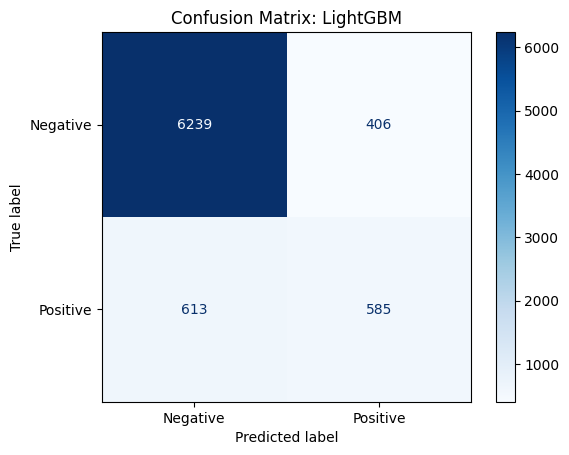

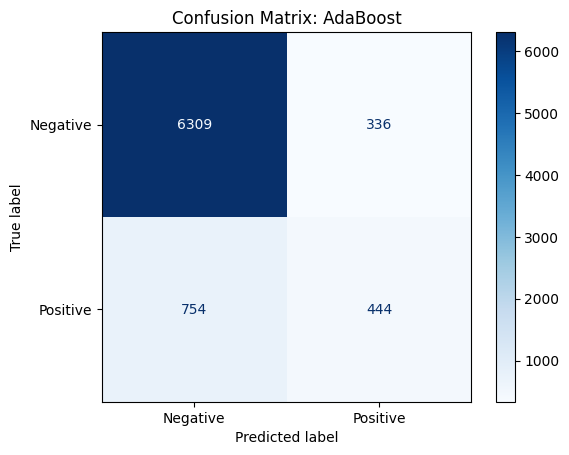

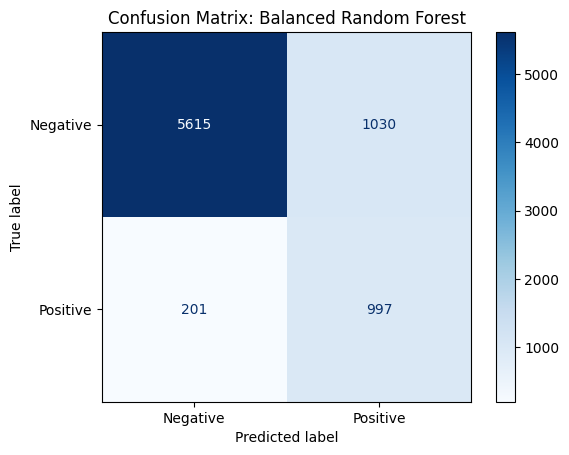

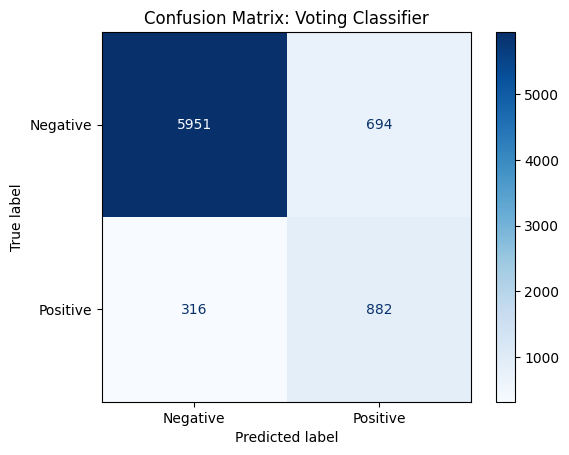

                    Model  Accuracy  Precision    Recall  F1 Score
0                LightGBM  0.870075   0.750425  0.713608  0.729496
1                AdaBoost  0.861023   0.731239  0.660027  0.684711
2  Balanced Random Forest  0.843045   0.728650  0.838608  0.759753
3       Voting Classifier  0.871223   0.754611  0.815894  0.778842


In [130]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = {
    "LightGBM": lgbm_best,
    "AdaBoost": ada_best,
    "Balanced Random Forest": brf_best,
    "Voting Classifier": voting_clf
}

metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    metrics["Model"].append(model_name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)
    
    cm = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

metrics_df = pd.DataFrame(metrics)


print(metrics_df)

1.	Best Performing Model: LightGBM leads in accuracy (87.01%), precision (75.04%), and F1 score (72.95%), making it the top choice for applications where overall performance and a balance between precision and recall are important. It may not be the best at recall, but its higher precision helps minimize false positives.
2.	Balanced Random Forest: While it has the highest recall (84.17%), Balanced Random Forest lags in accuracy and precision, which makes it ideal for imbalanced datasets where missing positive cases (false negatives) is particularly undesirable. This model would be most suitable when the cost of missing a positive instance outweighs the cost of a false positive.
3.	AdaBoost: AdaBoost has the lowest recall (66.00%) and F1 score (68.47%), making it a suboptimal choice in situations where recall is crucial. Its precision is also lower than that of LightGBM, indicating a higher rate of false positives. AdaBoost might still be useful for simpler problems but isn’t as robust for more complex, imbalanced, or noisy data.
4.	Voting Classifier: The Voting Classifier performs well with a good trade-off between precision and recall (F1 score of 77.82%). It slightly outperforms AdaBoost but does not surpass LightGBM or Balanced Random Forest in any specific metric. It might be a reliable option when combining the strengths of different models (through ensembling) is desirable.


In [131]:
voting_clf.fit(X, y)

VotingClassifier(estimators=[('brf',
                              Pipeline(steps=[('ctf2',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('onehot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['job',
                                                                                 'loan',
                                                                                 'marital',
                                                                                 'housing']),
                                                                               ('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['education',
                                                                                 'default',
                                                                                 'poutcome'])])),
                                              ('model',
                                               BalancedRandomForestClassifier(bootstrap=False,
                                                                              n_estimators=300,
                                                                              random_st...
                                                              verbosity=-1))])),
                             ('ada',
                              Pipeline(steps=[('ctf2',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('onehot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['job',
                                                                                 'loan',
                                                                                 'marital',
                                                                                 'housing']),
                                                                               ('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['education',
                                                                                 'default',
                                                                                 'poutcome'])])),
                                              ('model',
                                               AdaBoostClassifier(learning_rate=1.5,
                                                                  n_estimators=700,
                                                                  random_state=42))]))],
                 voting='soft')

# Training on entire train data and making predictions

In [125]:
voting_clf.fit(X, y)

VotingClassifier(estimators=[('brf',
                              Pipeline(steps=[('ctf2',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('onehot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['job',
                                                                                 'loan',
                                                                                 'marital',
                                                                                 'housing']),
                                                                               ('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['education',
                                                                                 'default',
                                                                                 'poutcome'])])),
                                              ('model',
                                               BalancedRandomForestClassifier(bootstrap=False,
                                                                              n_estimators=200))])),
                             ('lg...
                                                              verbosity=-1))])),
                             ('ada',
                              Pipeline(steps=[('ctf2',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('onehot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['job',
                                                                                 'loan',
                                                                                 'marital',
                                                                                 'housing']),
                                                                               ('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['education',
                                                                                 'default',
                                                                                 'poutcome'])])),
                                              ('model',
                                               AdaBoostClassifier(learning_rate=1.5,
                                                                  n_estimators=700,
                                                                  random_state=42))]))],
                 voting='soft')

In [132]:
test_predictions = voting_clf.predict(test_data)

test_predictions_labels = le_y.inverse_transform(test_predictions)

submission_df = pd.DataFrame({'id': test_data.index, 'target': test_predictions_labels})

submission_df.to_csv('submission.csv', index=False)

## ---------------------END OF PROJECT--------------------